# MNEflow basic example

# 1. Importing data

### 1.1.from MNE epochs

If you use MNE-python, all you need is to provide your epochs file (or list of epoch files) to mneflow.produce_tfrecords


In [1]:
%pylab inline
#get epochs using your mne-python pipeline
import os
from time import time
os.chdir('/m/nbe/work/zubarei1/mneflow/')

import mne
from mne.datasets import multimodal
import mneflow

mne.set_log_level(verbose='CRITICAL')

fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
raw = mne.io.read_raw_fif(fname_raw)

cond = raw.acqparser.get_condition(raw, None)
#get the list of condition names
condition_names = [k for c in cond for k,v in c['event_id'].items()]

epochs_list = [mne.Epochs(raw, **c) for c in cond]

#here we concatenate epochs because each input file contains just one condition
#otherwise mneflow.produce_tfrecords can handle a list of epochs objects
epochs = mne.concatenate_epochs(epochs_list)
#pick only planar gradiometers
epochs = epochs.pick_types(meg='grad')

Populating the interactive namespace from numpy and matplotlib


### Convert epochs to TFRecord format

In [2]:
#Specify import options
import_opt = dict(savepath='../tfr/', #path where TFR files will be saved
                   out_name='mne_sample_epochs', #name of TFRecords files
                   scale=True, #apply baseline_scaling
                   crop_baseline=True, #remove baseline interval after scaling
                   decimate = 2,
                   scale_interval=(0,60), #indices in time axis corresponding to baseline interval
                   val_size=0.15,
                   overwrite=False) #validations set size set to 15% of all data


#write TFRecord files and metadata file to disk
meta = mneflow.produce_tfrecords(epochs,**import_opt)  

## Other import options
### 1.2 Saved mne.epochs (*-epo.fif) files
Alternatively, if your epochs are saved to disk provide a str (or list of str) with path(s) to your -epo.fif files

e.g. this will work

```python
epochs.save('test_saved_epochs.fif')
meta = mneflow.produce_tfrecords('test_saved_epochs.fif',**opt)
```
### 1.3. Arrays in *.mat or *.npz format
if the first argument is str mneflow.produce_tfrecords can also accept *.mat or *.npz format

e.g.

```python
data_path = '/m/nbe/scratch/braindata/izbrv/detection_data/'
filenames = [data_path +'sub' + str(i) + '-grad.npz' for i in range(1,4)]
meta = mneflow.produce_tfrecords(filenames,**opt)
```
In this case, specify iput_type='array', and also provide array_keys keyword argument

e.g. 

```python
array_keys={'X':'my_data_samples','y':'my_labels'}
```

### 1.4. Tuple of (data, labels)
Finally, if you have a more complex preprocessing pipeline, you can feed you data and labels as a tuple of arrays

```python
X = epochs.get_data()
y = epochs.events[:,2]
meta = mneflow.produce_tfrecords((X,y),**opt)
```


# 2. Initialize the dataset object using the generated metadata file

The dataset object includes several methods that allow experimenting with the dataset without the need to repeat the preprocessing or overwriting the TFRecord files each time.

For example, you can train the model using any subset of classes, channels or reduce the sampling rate by decimating across the time domain.

In [3]:
dataset = mneflow.Dataset(meta, train_batch = 200, class_subset=None, pick_channels=None, decim=None)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


# 3. Choose from already implemented models

MNEflow pipeline consists of three major parts:
1. dataset
2. optimizer
3. computational graph

Each part has its own set of hyper-parameters and methods that can be tuned. See help for mneflow.Dataset
and mneflow.Optimizer and mneflow.models.Model for more details.
In this example will we use LF-CNN network


In [4]:
#specify optimizer parmeters
optimizer_params = dict(l1_lambda=3e-4,learn_rate=3e-4)

optimizer = mneflow.Optimizer(optimizer_params)

In [5]:
#specify parameters specific to LF-CNN
lf_params = dict(n_ls=64, #number of latent factors
              filter_length=17, #convolutional filter length in time samples
              pooling = 5, #pooling factor
              stride = 5, #stride parameter for pooling layer
              padding = 'SAME',
              dropout = .5,
              model_path = import_opt['savepath']) #path for storing the saved model

#initialize the model using the dataset and optimizer objects, and the hyper-parameter dictionary
model = mneflow.models.LFCNN(dataset, optimizer, lf_params)

#this will initialize the iterators over the dataset,the computational graph and the optimizer
model.build()

Instructions for updating:
Colocations handled automatically by placer.
de-mix _init
conv _init
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
fc _init
y_pred: (?, 8)
Initialization complete!


In [6]:
#train the model
start = time()
model.train(n_iter=3000,eval_step=250,min_delta=1e-6,early_stopping=1)
stop = time() - start
print('Trained in {:.2f}s'.format(stop))

i 0, tr_loss 2.97275, tr_acc 0.115 v_loss 2.57385, v_acc 0.163121
i 250, tr_loss 1.00755, tr_acc 0.86 v_loss 1.09022, v_acc 0.886525
i 500, tr_loss 0.579741, tr_acc 0.975 v_loss 0.723844, v_acc 0.929078
i 750, tr_loss 0.482634, tr_acc 0.995 v_loss 0.63499, v_acc 0.929078
i 1000, tr_loss 0.42775, tr_acc 0.99 v_loss 0.581652, v_acc 0.957447
i 1250, tr_loss 0.388496, tr_acc 0.995 v_loss 0.532652, v_acc 0.950355
i 1500, tr_loss 0.413392, tr_acc 0.97 v_loss 0.491152, v_acc 0.943262
i 1750, tr_loss 0.303071, tr_acc 1 v_loss 0.457967, v_acc 0.950355
i 2000, tr_loss 0.267468, tr_acc 1 v_loss 0.434023, v_acc 0.950355
i 2250, tr_loss 0.257005, tr_acc 1 v_loss 0.412281, v_acc 0.957447
i 2500, tr_loss 0.220208, tr_acc 1 v_loss 0.394443, v_acc 0.957447
i 2750, tr_loss 0.212093, tr_acc 0.995 v_loss 0.375953, v_acc 0.957447
i 3000, tr_loss 0.183225, tr_acc 1 v_loss 0.359286, v_acc 0.957447
Trained in 191.41s


# 4. Explore the trained model parameters
LFCNN allows to interpret the trained parameters in terms of toporaphies and the spectral properties of the latent sources contributing to each class. 

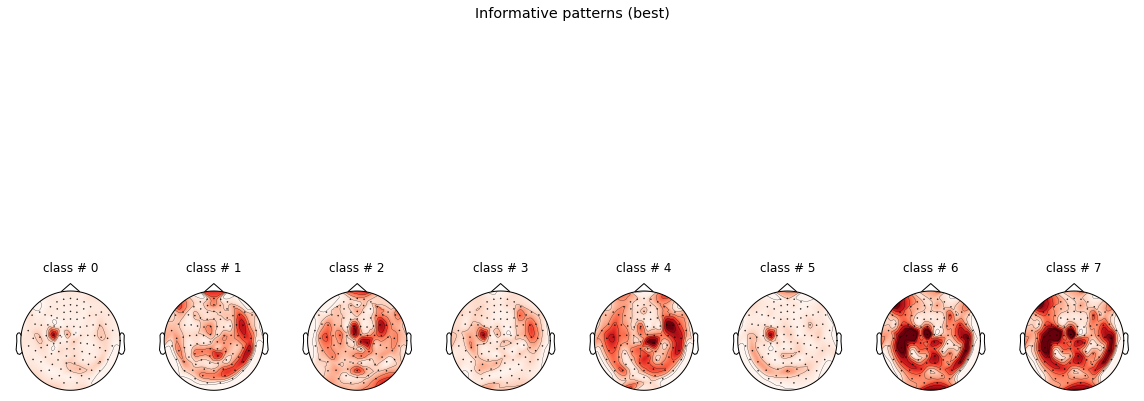

In [7]:
model.compute_patterns('patterns')
#model.plot_out_weihts()
f = model.plot_patterns(sensor_layout='Vectorview-grad', sorting='best', spectra=False, scale=True)


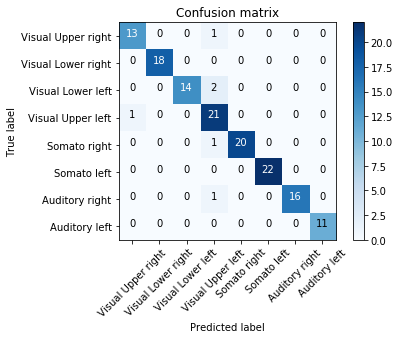

In [8]:
#Plotting the confusion matrix allows to identify analyze whether cetrain classes 
#are systematically harder to classify 
f2 = model.plot_cm(dataset='validation', class_names = condition_names)